In [1]:
import json
import numpy as np
from pathlib import Path

np.set_printoptions(precision=6)
np.set_printoptions(suppress=True)

In [2]:
with open("../../input/sensorIDtoSectorID.json", "r") as f:
    sensorIDdict = json.load(f)
    sectorIDlut = np.empty(len(sensorIDdict))

    # create a look up table for fast sensorID -> sectorID translation
    for key, value in sensorIDdict.items():
        sectorIDlut[int(key)] = value

def readRecoHitsFromCSVFile(filename):
    csvValues = np.genfromtxt(filename, delimiter=",")
    # check if there really are n times 4 elements
    if len(csvValues) % 4 != 0:
        raise ValueError('entries are not a multiple of 4!')
    
    nEvents = int(len(csvValues) / 4)

    ids = np.array(csvValues[:,0],dtype=int)
    csvValues[:,0] = sectorIDlut[ids]

    csvValues = csvValues.reshape((nEvents,4,4))

    return csvValues

def reject_outliers(data, m = 10.):
    """
    https://stackoverflow.com/a/16562028
    """
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]


In [3]:
def loadMatrices(filename):
    with open(filename) as f:
        result = json.load(f)
    for key, value in result.items():
        result[key] = np.array(value).reshape(4, 4)
    return result


detectorMatrices = loadMatrices("../../input/detectorMatricesIdeal.json")
matToLMD = np.linalg.inv(np.array(detectorMatrices["/cave_1/lmd_root_0"]))


In [4]:
class  CorridorFitter:
    def __init__(self, tracks):
        self.tracks = tracks
        self.nTrks = len(self.tracks)
        self.useAnchor = False

    def useAnchorPoint(self, point):
        assert len(point) == 3 or len(point) == 4
        self.anchorPoint = point
        self.useAnchor = True

    def fitTracksSVD(self):

        self.fittedTrackArr = np.zeros((self.nTrks, 2, 3))

        for i in range(self.nTrks):
            # cut fourth entry, sometimes this is the sensorID or homogeneous coordinate
            trackRecos = self.tracks[i][:, :3]

            if self.useAnchor:
                trackRecos = np.vstack((self.anchorPoint[:3], trackRecos))

            # see https://stackoverflow.com/questions/2298390/fitting-a-line-in-3d
            meanPoint = trackRecos.mean(axis=0)
            _, _, vv = np.linalg.svd(trackRecos - meanPoint)

            self.fittedTrackArr[i][0] = meanPoint

            # flip tracks that are fitted backwards
            if vv[0, 2] < 0:
                self.fittedTrackArr[i][1] = -vv[0]
            else:
                self.fittedTrackArr[i][1] = vv[0]

        return self.fittedTrackArr
        

In [5]:
from numpy import array, cross
from numpy.linalg import solve


def findPointOfClosestDistance(p1, d1, p2, d2):
    """
    Give two lines in 3D Space (each defined by direction vector d and a point on the line p), calculates points in 3D space (on lines 1 and two) where the distance between them in minimal.

    Credits to
    - https://math.stackexchange.com/a/3334866
    - https://math.stackexchange.com/q/1993990
    """

    # if lines A and B are defined by point and direction
    XA0 = p1
    XA1 = p1 + d1
    XB0 = p2
    XB1 = p2 + d2

    # at this point, XA0 and XA1 must be points, not directions!

    UA = XA1 - XA0
    UB = XB1 - XB0
    UC = cross(UB, UA)

    # solve the system derived in user2255770's answer from StackExchange: https://math.stackexchange.com/q/1993990
    RHS = XB0 - XA0
    LHS = array([UA, -UB, UC]).T
    tVec = solve(LHS, RHS)

    #! this is wrong if d1,2 are points, not directions
    return p1 + tVec[0] * d1, p2 + tVec[1] * d2


In [6]:
def skewLinesClosestPoints(p1, d1, p2, d2):
    """
    the two lines v1 and v2 are given by a point on each line p1,p2 and the direction vectors d1,d2

    formula from Wikipedia:
    https://en.wikipedia.org/wiki/Skew_lines
    Original credit
    https://math.stackexchange.com/a/1702955/268680
    """
    n = np.cross(d1, d2)
    n1 = np.cross(d1, n)
    n2 = np.cross(d2, n)

    frac1 = np.dot(p2 - p1, n2) / np.dot(d1, n2)
    frac2 = np.dot(p1 - p2, n1) / np.dot(d2, n1)

    c1 = p1 + frac1 * d1
    c2 = p2 + frac2 * d2

    return c1, c2


In [7]:
def skewLinesClosestPointsVectorized(p1, d1, p2, d2):
    """
    the two lines v1 and v2 are given by a point on each line p1,p2 and the direction vectors d1,d2

    vectorized version: p1,2 and d1,2 are vectors of vectors

    formula from Wikipedia:
    https://en.wikipedia.org/wiki/Skew_lines
    Original credit
    https://math.stackexchange.com/a/1702955/268680
    """
    n = np.cross(d1, d2)
    n1 = np.cross(d1, n)
    n2 = np.cross(d2, n)

    # calculate pair wise dot product of the two vectors of vectors
    upperDot1 = np.einsum("ij,ij->i", p2 - p1, n2)
    lowerDot1 = np.einsum("ij,ij->i", d1, n2)
    upperDot2 = np.einsum("ij,ij->i", p1 - p2, n1)
    lowerDot2 = np.einsum("ij,ij->i", d2, n1)

    # vectors of fractions, one for each track
    frac1 = upperDot1 / lowerDot1
    frac2 = upperDot2 / lowerDot2

    # vectorized point calulation
    c1 = p1 + frac1[:, np.newaxis] * d1
    c2 = p2 + frac2[:, np.newaxis] * d2

    return c1, c2


In [56]:
def findAnchorPoints(recoArray):

    # find anchor point by projecting the track towards the IP.
    anchorPoints = {}

    # translate the reco hits to format for module Aligner
    for iSector in range(10):
        # apply mask so only one sector is chosen
        # careful, this only checks if the first hit
        # is in the correct sector!
        sectorMask = recoArray[:, 0, 0] == iSector

        # create new empty array thay has the required structure
        sectorTracksXYZ = recoArray[sectorMask][:, :, 1:4]
        nTrks = len(sectorTracksXYZ)

        # assign recos from input array to new array for this sector
        trackVectorInPND = np.ones((nTrks, 6, 4))
        trackVectorInPND[:, 2:6, :3] = sectorTracksXYZ[:, 0:4]


        # transform to LMD local (easier math)
        trackVectorInLMD = np.ones(trackVectorInPND.shape)
        for iPlane in range(4):
            trackVectorInLMD[:, iPlane + 2] = (matToLMD @ trackVectorInPND[:, iPlane + 2].T).T
        # print(trackVectorInLMD[:3])

        # perform one track fit so that we have point and direction for all tracks
        recosInLMD = trackVectorInLMD[:, 2:6]
        corrFitter = CorridorFitter(recosInLMD)
        fittedTracksInLMD = corrFitter.fitTracksSVD()

        # print(f'{fittedTracksInLMD[:3]}')

        # then find intersection with local z axis, UNROLLED version

        nTrk = len(fittedTracksInLMD)

        tracksPointVector = fittedTracksInLMD[:, 0]
        tracksDirectionVector = fittedTracksInLMD[:, 1]

        # make two vectors of vectors for z axes
        zAxisPointVector = np.zeros((tracksPointVector.shape))
        zAxisDirectionVec = np.zeros((tracksPointVector.shape))
        zAxisDirectionVec[:, 2] = 1

        c1Points, c2Points = skewLinesClosestPointsVectorized(zAxisPointVector, zAxisDirectionVec, tracksPointVector, tracksDirectionVector)

        # reject outliers, calculate mean 
        zCoordsOfAnchors = reject_outliers(c2Points[:,2])
        meanZ = np.average(zCoordsOfAnchors)

        # store
        anchorPoints[str(iSector)] = meanZ

    return anchorPoints


In [57]:
fileList = []

fileList.append(Path("../../input/recos-1.5-aligned.csv"))
fileList.append(Path("../../input/recos-4.06-aligned.csv"))
fileList.append(Path("../../input/recos-8.90-aligned.csv"))
fileList.append(Path("../../input/recos-11.91-aligned.csv"))
fileList.append(Path("../../input/recos-15.00-aligned.csv"))

for file in fileList:
    reocs = readRecoHitsFromCSVFile(file)
    anchorPoints = findAnchorPoints(reocs)
    anchorPoints["version"] = 1     # makes it easier for aligner
    jsonName = ("../../output/" + str(file.stem) + ".json").replace('recos', 'anchorPoints')
    with open(jsonName, "w") as f:
        json.dump(anchorPoints, f, indent=4, sort_keys=True)


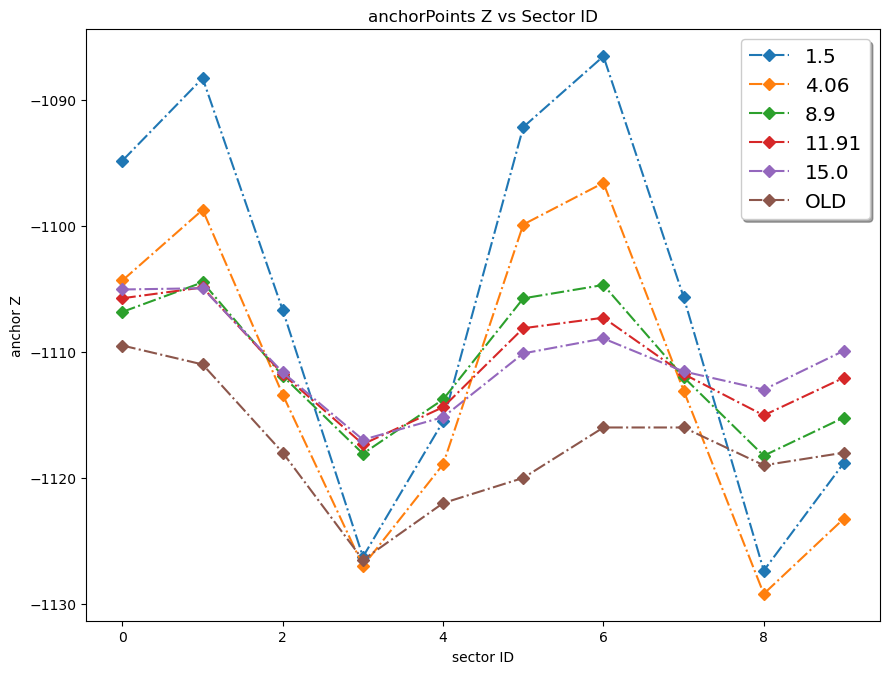

In [61]:
# plot result
import matplotlib.pyplot as plt

fileList = []

fileList.append(Path("../../output/anchorPoints-1.5-aligned.json"))
fileList.append(Path("../../output/anchorPoints-4.06-aligned.json"))
fileList.append(Path("../../output/anchorPoints-8.90-aligned.json"))
fileList.append(Path("../../output/anchorPoints-11.91-aligned.json"))
fileList.append(Path("../../output/anchorPoints-15.00-aligned.json"))

labels = ("1.5", "4.06", "8.9", "11.91", "15.0", "OLD")


fig = plt.figure(figsize=(1024 / 100, 768 / 100))
ax = fig.add_subplot(1, 1, 1)

i = 0

anchors = []

# prepare new anchorPoints
for file in fileList:
    with open(file, "r") as f:
        anchorPoints = json.load(f)
        # remove version key, just for plotting
        anchorPoints.pop('version', None)

    anchorsArray = []

    # damn I wish I could plan better
    for key, value in anchorPoints.items():
        anchorsArray.append([int(key), value])

    anchors.append(anchorsArray)

# add old anchorPoints, they have a different format

oldAnchorPath = "../../comparisonData/oldInput/moduleAlignment/anchorPoints.json"
with open(oldAnchorPath, 'r') as f:
    oldAnchors = json.load(f)
    anchorsArray = []
    for key, value in oldAnchors.items():
        anchorsArray.append([int(key), value[2]])
    anchors.append(anchorsArray)


for anchorsArray in anchors:

    # thank god dynamic typing is a thing
    anchorsArray = np.array(anchorsArray)

    # print(f"{anchorsArray = }")
    ax.set_title('anchorPoints Z vs Sector ID')
    ax.set_xlabel("sector ID")
    ax.set_ylabel("anchor Z")
    ax.plot(
        anchorsArray[:, 0],
        anchorsArray[:, 1],
        label=labels[i],
        linestyle="-.",
        marker="D",
    )
    legend = ax.legend(loc="upper right", shadow=True, fontsize="x-large")
    # legend.get_frame().set_facecolor('C0')
    i += 1

plt.show()
# break
